Student Name: Aswani Pottathuparambil Unnikrishnan
Student Id: 8858117

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from keras.utils import to_categorical
import pathlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [41]:
PIXEL_SIZE = 224
data_folder_path = pathlib.Path('C:/Users/aswan/OneDrive/Desktop/FML/Birds')


In [50]:
# Train, Valid, Test data details
train_data = image_dataset_from_directory(
    data_folder_path / "train",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    batch_size=32)
validation_data = image_dataset_from_directory(
    data_folder_path / "valid",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    batch_size=32)
test_datas= image_dataset_from_directory(
    data_folder_path / "test",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    batch_size=32)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [51]:
y = np.concatenate([y for x, y in train_data], axis=0)

In [52]:
# Find top 3 classes
labels = pd.Series(y)
img_counts = labels.value_counts()
sorted_img_counts = img_counts.sort_values(ascending=False)
top3_classes = sorted_img_counts[:3]


In [53]:
top3_class_list = top3_classes.index.to_list()
top3_class_list

[434, 291, 374]

In [54]:
# Display top 3 class names
cls_names = train_dataset.class_names
top3_clz_names = [cls_names[i] for i in top3_class_list]
top3_clz_names

['RUFOUS TREPE', 'HOUSE FINCH', 'OVENBIRD']

In [66]:
# Copied selected top3 classes into  train3, valid3, test3 folders manually
# Replace the train, valid, test data with top 3 classes
# seting path to the dataset
train_data = pathlib.Path(data_folder / "train3")
test_data = pathlib.Path(data_folder / "test3")
valid_data = pathlib.Path(data_folder / "valid3")

Data Augmentation

In [67]:
# creating data augmentation 
image_size = (224, 224)
batch_size = 64

data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip=True,
)

In [68]:
# Create data generators - training, validation, and testing data.
train_generator = data_gen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_directory(
    valid_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    test_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 744 images belonging to 3 classes.


Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


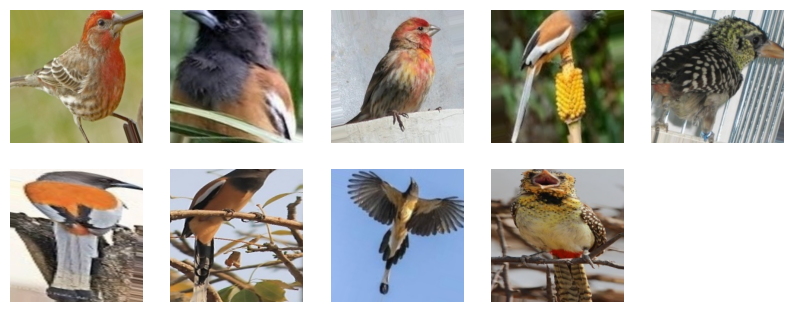

In [72]:
# Dispaly train image batch
images, _ = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

VGG16 Model

In [73]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(244,244,3)
)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [74]:
# Set the 'trainable' attribute of the 'conv_base' object to False. 
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [75]:
# create a new model -  add additional layers on top of an existing model conv_base.
x = conv_base.output
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(conv_base.input, outputs)

In [76]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0   

In [77]:
# compile and train neural network model.
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="../../data/models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks = callbacks
)

Epoch 1/10
12/12 [==============================] - 72s 6s/step - loss: 25.1062 - accuracy: 0.3925 - val_loss: 13.0606 - val_accuracy: 0.5333
Epoch 2/10
12/12 [==============================] - 64s 5s/step - loss: 12.7982 - accuracy: 0.6277 - val_loss: 9.8939 - val_accuracy: 0.6000
Epoch 3/10
12/12 [==============================] - 95s 7s/step - loss: 7.6855 - accuracy: 0.7419 - val_loss: 1.7193 - val_accuracy: 0.9333
Epoch 4/10
12/12 [==============================] - 50s 4s/step - loss: 5.1319 - accuracy: 0.8024 - val_loss: 0.4838 - val_accuracy: 0.9333
Epoch 5/10
12/12 [==============================] - 61s 5s/step - loss: 4.0052 - accuracy: 0.8508 - val_loss: 0.1181 - val_accuracy: 0.9333
Epoch 6/10
12/12 [==============================] - 62s 5s/step - loss: 3.4780 - accuracy: 0.8763 - val_loss: 2.1053e-04 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 72s 6s/step - loss: 3.0303 - accuracy: 0.8871 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/1

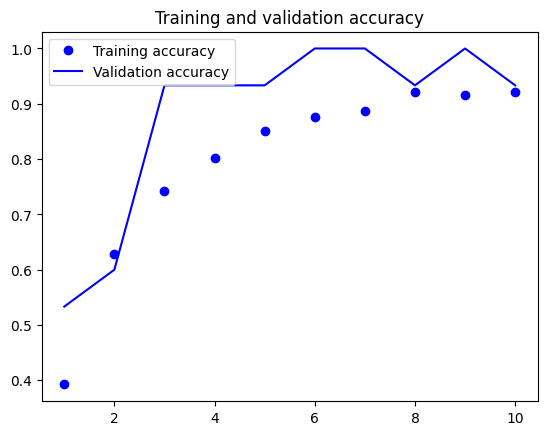

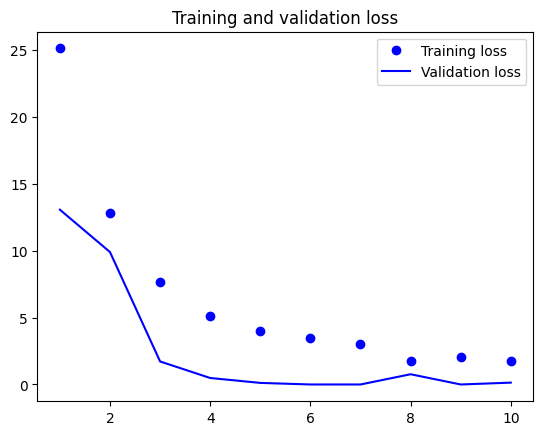

In [78]:
# plot the training and validation accuracy 
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [79]:
# evaluating the performance of the model on a test dataset.
test_loss, test_acc = model.evaluate(test_generator)
val_loss, val_acc = model.evaluate(val_generator)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}\n")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Validation Loss: {val_loss:.3f}")

1/1 [==============================] - 1s 965ms/step - loss: 1.1006e-05 - accuracy: 1.0000
Test accuracy: 1.000
Test Loss: 0.000

Validation accuracy: 1.000
Validation Loss: 0.000


In [80]:
# generating confusion metrics and classification report for the model.
y_pred = model.predict(test_generator)
y_predict =  np.argmax(y_pred, axis =1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true,y_predict)
class_report = classification_report(y_true, y_predict, target_names=test_generator.class_indices.keys())
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

1/1 [==============================] - 1s 958ms/step
Confusion Matrix:
 [[1 3 1]
 [2 1 2]
 [2 1 2]]

Classification Report:
                   precision    recall  f1-score   support

D-ARNAUDS BARBET       0.20      0.20      0.20         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.40      0.40      0.40         5

        accuracy                           0.27        15
       macro avg       0.27      0.27      0.27        15
    weighted avg       0.27      0.27      0.27        15



AUC for D-ARNAUDS BARBET: 0.35797619047619045
AUC for HOUSE FINCH: 0.38607142857142857
AUC for RUFOUS TREPE: 0.5223809523809524


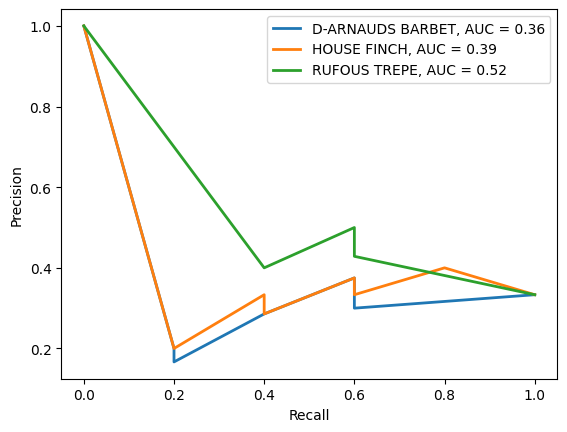

In [81]:
# calculating the precision-recall curve and the area under the curve (AUC) for each class.
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in val_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

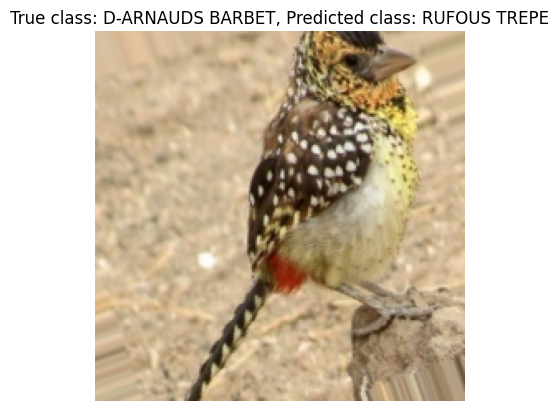

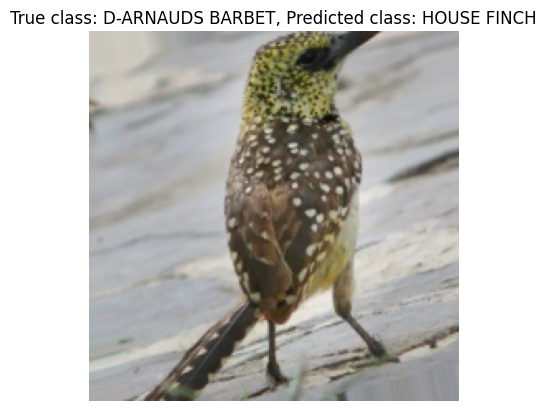

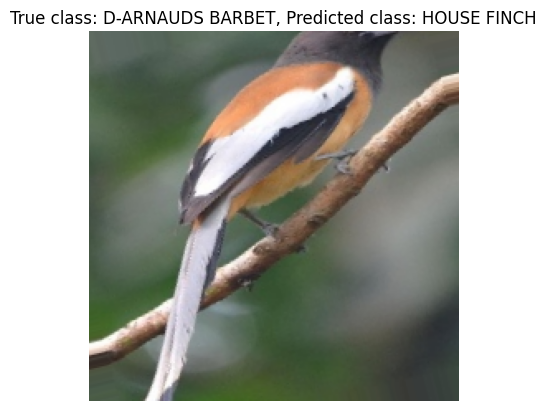

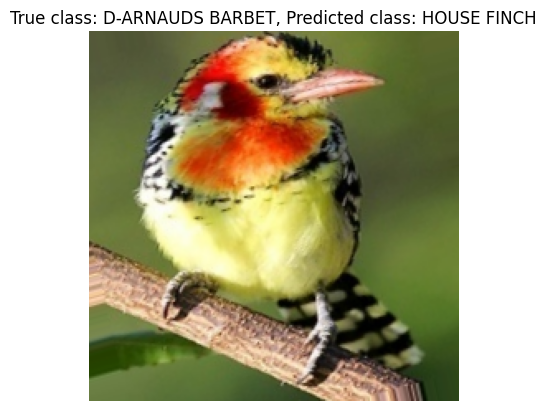

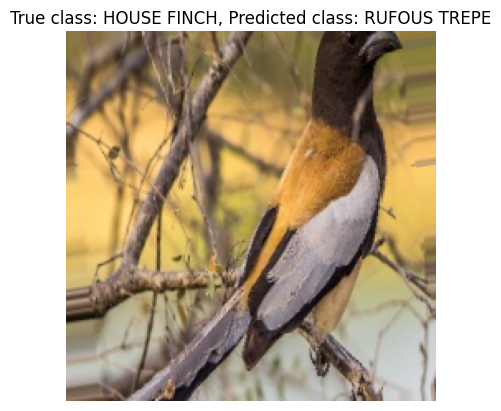

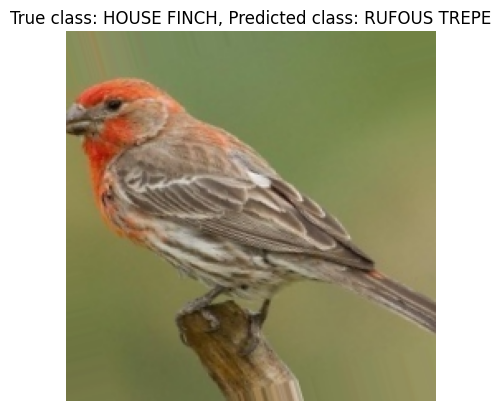

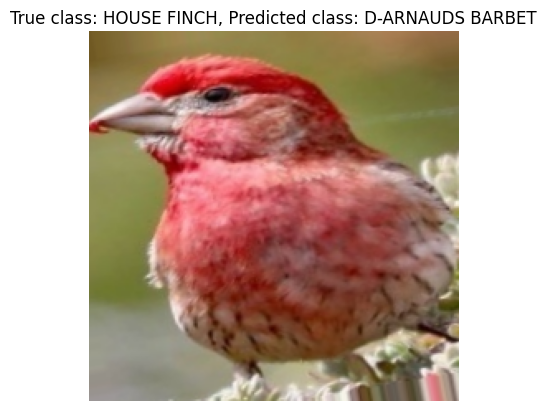

In [84]:
# plotting missclassified examples
misclassfied_index = np.where(y_predict!= y_true)[0]


for index in misclassfied_index[:7]:
    # get image from corresponding batch
    img_batch, _ = val_generator[index // val_generator.batch_size]
    img = img_batch[index % val_generator.batch_size]
    
    true_class_name = class_names[y_true[index]]
    predicted_class_name = class_names[y_predict[index]]

    plt.imshow(img.astype('uint8'))
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()

Observation 

* "RUFOUS TREPE," which has the greatest AUC value. The AUC values, however, are not especially high, indicating that the model's performance might be enhanced.
* The model appears to perform poorly, as evidenced by its poor accuracy, recall, and F1-scores across all classes. This shows that the model may be having trouble differentiating between the classes, either as a result of an unbalanced data set or other problems. 